# ***Proyecto 02: Ingeniería de features, Modelos avanzados e Interpretación de modelos***

# **Resumen del proyecto**

Aplica ingeniería de Features y Modelos Avanzados para desarrollar con mayor profundidad tu modelo de Machine Learning.

# **Consigna**

En este proyecto profundizarás lo desarrollado en el proyecto 01 (“Primer modelo de Machine Learning”). El objetivo es aplicar las técnicas incorporadas (Transformación de Datos, Optimización de Hiperparámetros, Modelos Avanzados, etc.) para generar un modelo que tenga un mejor desempeño que el modelo generado en el proyecto anterior. Luego, interpreta ese modelo para responder la siguiente pregunta: ¿qué podemos aprender de nuestro problema estudiando el modelo que generamos?

# **PARTE A - Transformación de Datos**

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Implementa las transformaciones que elegiste. Es importante que justifiques por qué las haces:

1 - Detección y eliminación de Outliers




2 - Encoding




3 - Imputación de valores faltantes




4 - Escalado de datos




5 - Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).




Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - con este nuevo dataset transformado. Evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Compara con el desempeño obtenido en el proyecto 01. Sea cual sea la respuesta, intenta explicar a qué se debe.

# **Inicio**

Importamos todas las librerías con las que vamos a trabajar durante el proyecto

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from numpy import nan as NA

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

Cargamos el dataset 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data= pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/DS_Proyecto_01_Datos_Properati.csv")

Reviso el tamaño que contiene el dataset 

In [ ]:
nro_columnas = data.shape[1]
nro_filas = data.shape[0]

print('El dataset tiene un total de {} columnas y {} instancias'.format(nro_columnas, nro_filas))

El dataset tiene un total de 19 columnas y 146660 instancias


Voy a mantener los filtros realizados en el proyecto 1, para tener la misma base de trabajo y después poder comparar el rendimiento del modelo con el
preprocesamiento realizado. Descarté la columna 'surface_covered' dada su alta correlación con surface total, con ésta última variable nos es suficiente
para trabajar. 

In [ ]:
filtro_a= data[(data.property_type.isin(['Casa','Departamento','PH']))&(data.l2=='Capital Federal')]
filtro_data=filtro_a[['property_type','rooms','bedrooms','bathrooms','surface_total','surface_covered','price']]
#filtro_data.shape
print(f'Contamos con { filtro_data.shape[0] } registros y { filtro_data.shape[1] } columnas.')

Contamos con 91485 registros y 7 columnas.


Hago un filtrado para eliminar las propiedades que tienen surface_covered mayor al surface_total y las que poseen más bedrooms que rooms. Dado que es información inconsistente

In [ ]:
filtro_data.drop(labels=filtro_data.loc[filtro_data.surface_covered>filtro_data.surface_total].index, inplace= True)
filtro_data.drop(labels=filtro_data.loc[filtro_data.bedrooms>filtro_data.rooms].index, inplace= True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Con un shape verificamos que la porción eliminada no es significativa en cantidad por lo que voy a avanzar con el proyecto excluyendo las instancias que cumplen esta condición.

In [ ]:
filtro_data.shape

(90663, 7)

Voy a utilizar la clase OneHotEncoder para evitar que el modelo de machine learning interprete ordinalidad (0<1<2) en la codificación. 

In [ ]:
tipo_propiedades= filtro_data['property_type']
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtro_data['property_type'])
labels.shape

(90663,)

In [ ]:
one_hot_encoder = OneHotEncoder(sparse = False)
encoding = one_hot_encoder.fit_transform(labels.reshape(-1,1))
encoding.shape

(90663, 3)

In [ ]:
columns = pd.DataFrame(encoding, columns=['Casa', 'PH', 'Departamento'])

data= filtro_data.reset_index(drop=True)
data= pd.concat([data,columns], axis=1)
data['Casa']= data['Casa'].astype('int32')
data['PH']= data['PH'].astype('int32')
data['Departamento']= data['Departamento'].astype('int32')
data.head()

,property_type,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,PH,Departamento
0,Departamento,7.0,7.0,2.0,140.0,140.0,153000.0,0,1,0
1,PH,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1
2,PH,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1
3,PH,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1
4,PH,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1


***FUNCIÓN PARA GRAFICAR OUTLIERS***

In [ ]:
def graficar_outliers(columna, data=data, bins=30):
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    # BOXPLOT
    sns.boxplot(y=columna, data=data, color='Coral', fliersize=4, linewidth=2, saturation=1, ax=axs[0])    
    axs[0].set_xlabel(f'{ columna.upper() }', fontsize=10, labelpad=10, weight='bold')
    axs[0].set_ylabel(f'CANTIDAD', fontsize=10, labelpad=10, weight='bold')
    axs[0].tick_params(axis='both', labelsize=15)
    # DISTPLOT
    sns.histplot(x=columna, data=data, bins=bins, color='Royalblue', stat='probability', ax=axs[1])
    axs[1].set_xlabel(f'{ columna.upper() }', fontsize=10, labelpad=10, weight='bold')
    axs[1].set_ylabel('PROBABILIDAD', fontsize=10, labelpad=10, weight='bold')    
    axs[1].tick_params(axis='both', labelsize=15)

    fig.suptitle(f'Estudio outliers: { columna }'.upper(), y=1, fontsize=15, fontweight='bold')
    plt.show()

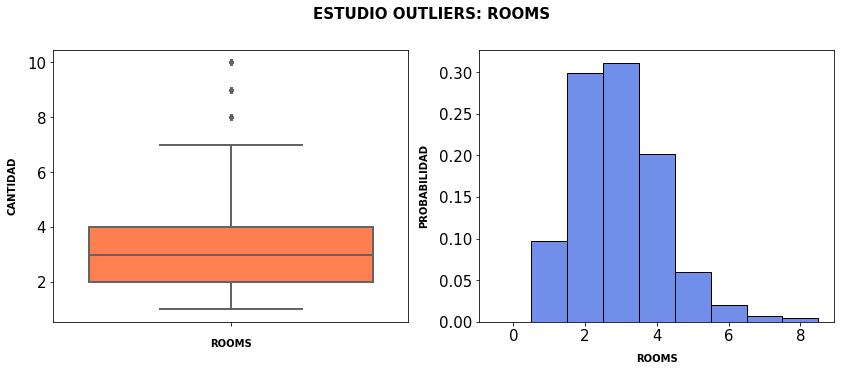

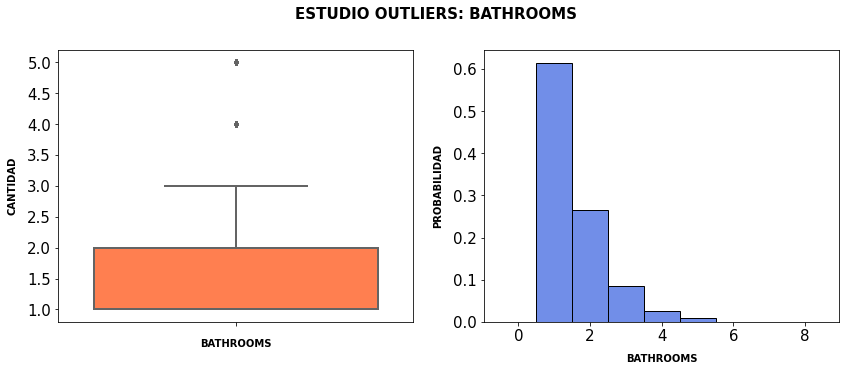

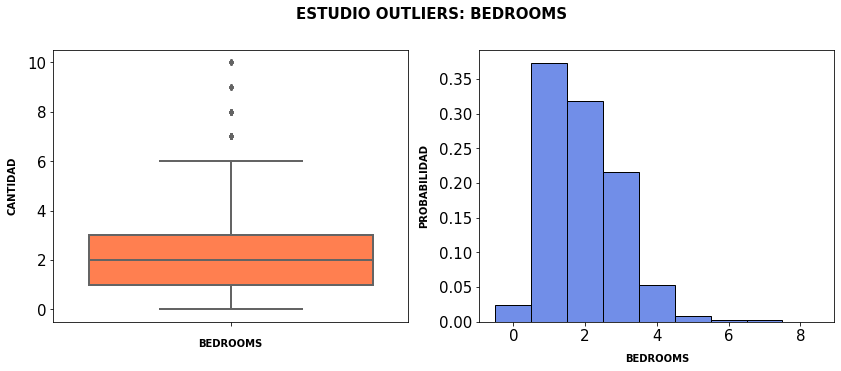

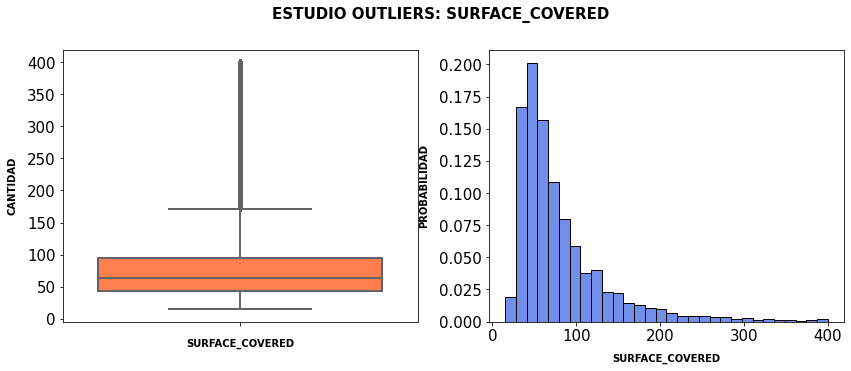

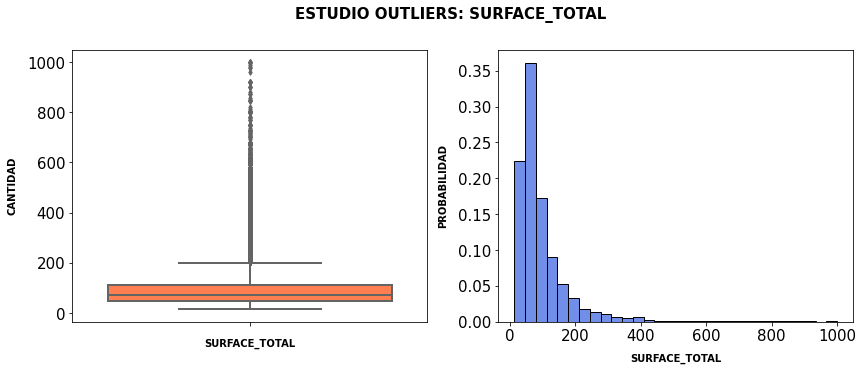

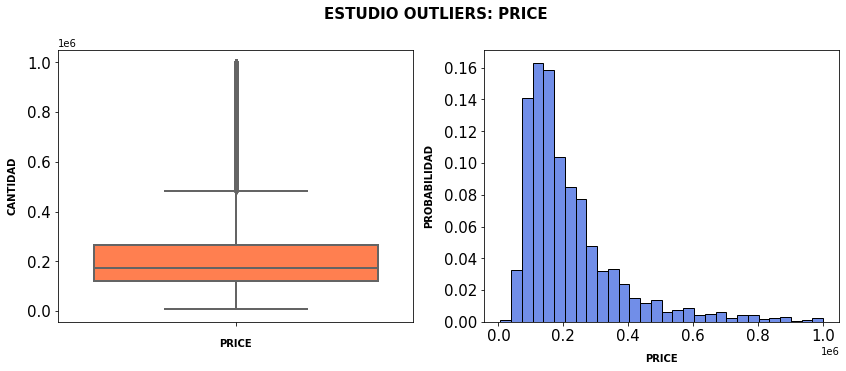

In [ ]:
data_out = data.query('rooms <= 10')
graficar_outliers('rooms', data_out, np.arange(10)-0.5)

data_out = data.query('bathrooms <= 5')
graficar_outliers('bathrooms', data_out, np.arange(10)-0.5)

data_out = data.query('bedrooms <= 10')
graficar_outliers('bedrooms', data_out, np.arange(10)-0.5)

data_out = data.query('(`surface_covered` <= `surface_total`) & (`surface_covered` >= 15 & `surface_covered` <= 400)')
graficar_outliers('surface_covered', data_out)

data_out = data.query('`surface_total` <= 1000 & `surface_total` >= 15')
graficar_outliers('surface_total', data_out)

data_out = data.query('price <= 1000000')
graficar_outliers('price', data_out)

En las gráficas se puede observar información como por ejemplo que la mediana para ***rooms*** es tres, la de ***bedrooms*** es dos y para ***bathrooms*** es uno. En cuanto a la variable **surface_total** su mediana es mayor a la de ***surface_covered*** como es de esperar. 
En todas las variables observamos la presencia de outliers que ahora vamos a proceder a trabajarlos.

# *Detección y eliminación de Outliers*

**Detección de Outliers para la variable price**

In [ ]:
q25,q75 = np.percentile(data.price.values,[25,75])
iqr = q75 - q25
minimo = q25 - 1.5*iqr
maximo = q75 + 1.5*iqr
print(q25,q75,iqr, minimo, maximo)

121600.0 279000.0 157400.0 -114500.0 515100.0


In [ ]:
mascara = (data.price < minimo) | (data.price > maximo)
mascara.sum()

7467

In [ ]:
data.drop(labels=data.loc[mascara].index, inplace= True)

In [ ]:
data.shape

(83196, 10)

**Detección de Outliers para la variable rooms**

In [ ]:
valor_medio = data.rooms.mean()
std = data.rooms.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers = np.logical_or(data.rooms < minimo , data.rooms > maximo)
print(minimo,maximo)

-0.6917782300587403 6.311832078801468


In [ ]:
mascara_dos = (data.rooms < minimo) | (data.rooms > maximo)
mascara_dos.sum()

611

In [ ]:
data.drop(labels=data.loc[mascara_dos].index, inplace= True)

**Detección de Outliers para la variable bathrooms**

In [ ]:
valor_medio = data.bathrooms.mean()
std = data.bathrooms.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers = np.logical_or(data.bathrooms < minimo , data.bathrooms > maximo)
print(minimo,maximo)

-0.5979884546077292 3.422420865557106


In [ ]:
mascara_tres = (data.bathrooms < minimo) | (data.bathrooms > maximo)
mascara_tres.sum()

971

In [ ]:
data.drop(labels=data.loc[mascara_tres].index, inplace= True)

**Detección de Outliers para la variable bedrooms**

In [ ]:
valor_medio = data.bedrooms.mean()
std = data.bedrooms.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers_dos = np.logical_or(data.bedrooms < minimo , data.bedrooms > maximo)
print(minimo,maximo)

-0.9321356965759715 4.529386168308762


In [ ]:
mascara_cuatro = (data.bedrooms < minimo) | (data.bedrooms > maximo)
mascara_cuatro.sum()

258

In [ ]:
data.drop(labels=data.loc[mascara_cuatro].index, inplace= True)

**Detección de Outliers para la variable surface covered**

In [ ]:
valor_medio = data.surface_covered.mean()
std = data.surface_covered.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers_dos = np.logical_or(data.surface_covered < minimo , data.surface_covered > maximo)
print(minimo,maximo)

-2351.0398446425147 2508.9418643868544


In [ ]:
mascara_cinco = (data.surface_covered < minimo) | (data.surface_covered > maximo)
mascara_cinco.sum()

75

In [ ]:
data.drop(labels=data.loc[mascara_cinco].index, inplace= True)

**Detección de Outliers para la variable surface total**

In [ ]:
valor_medio = data.surface_total.mean()
std = data.surface_total.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers_dos = np.logical_or(data.surface_total < minimo , data.surface_total > maximo)
print(minimo,maximo)

-1856.6594012132978 2030.137833498476


In [ ]:
mascara_seis = (data.surface_total < minimo) | (data.surface_total > maximo)
mascara_seis.sum()

46

In [ ]:
data.drop(labels=data.loc[mascara_seis].index, inplace= True)

In [ ]:
data.shape

(81235, 10)

**Imputación de valores faltantes**

In [ ]:
data.isna().sum()

property_type         0
rooms                 0
bedrooms              0
bathrooms          2052
surface_total      8232
surface_covered    8525
price                 0
Casa                  0
PH                    0
Departamento          0
dtype: int64

Dada la correlación entre ***bathrooms*** y ***rooms***, vamos a realizar una predicción para ***bathrooms*** tomando como referencia la variable ***rooms***.

In [ ]:
reg = LinearRegression()

In [ ]:
data_aux = data.dropna()
data_aux.head()

,property_type,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,PH,Departamento
1,PH,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1
2,PH,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1
3,PH,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1
4,PH,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1
5,PH,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1


In [ ]:
X = np.array(data_aux['rooms']).reshape(-1,1)
y = data_aux.bathrooms

In [ ]:
reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
data[data['bathrooms'].isnull()]

,property_type,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,PH,Departamento
292,Departamento,1.0,1.0,NaN,23.0,23.0,72000.0,0,1,0
301,Departamento,1.0,1.0,NaN,14.0,14.0,27000.0,0,1,0
378,Departamento,4.0,3.0,NaN,88.0,88.0,192000.0,0,1,0
404,Departamento,2.0,1.0,NaN,25.0,23.0,70000.0,0,1,0
429,Departamento,1.0,0.0,NaN,38.0,32.0,85000.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
86405,Departamento,2.0,1.0,NaN,59.0,58.0,169000.0,0,1,0
87058,Departamento,2.0,1.0,NaN,67.0,67.0,130000.0,0,1,0
87081,Departamento,3.0,2.0,NaN,72.0,68.0,255000.0,0,1,0
87743,Departamento,3.0,2.0,NaN,80.0,80.0,280000.0,0,1,0


In [ ]:
data[data['bathrooms'].isnull()].rooms

292      1.0
301      1.0
378      4.0
404      2.0
429      1.0
        ... 
86405    2.0
87058    2.0
87081    3.0
87743    3.0
90563    2.0
Name: rooms, Length: 2052, dtype: float64

In [ ]:
bathrooms_completar = reg.predict(np.array(data[data['bathrooms'].isnull()].rooms).reshape(-1,1))

In [ ]:
data.loc[data['bathrooms'].isnull(),'bathrooms'] = bathrooms_completar

In [ ]:
data

,property_type,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,PH,Departamento
1,PH,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1
2,PH,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1
3,PH,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1
4,PH,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1
5,PH,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
90652,Departamento,3.0,2.0,2.0,82.0,82.0,475000.0,0,1,0
90653,PH,3.0,2.0,1.0,84.0,84.0,178000.0,0,0,1
90654,PH,5.0,2.0,2.0,114.0,95.0,298000.0,0,0,1
90659,PH,3.0,2.0,2.0,144.0,134.0,480000.0,0,0,1


In [ ]:
data.isna().sum()

property_type         0
rooms                 0
bedrooms              0
bathrooms             0
surface_total      8232
surface_covered    8525
price                 0
Casa                  0
PH                    0
Departamento          0
dtype: int64

In [ ]:
data.shape

(81235, 10)

Ahora voy a llenar los datos faltantes de las columnas ***surface_covered*** y ***surface_total***.
Para ***surface_total*** opté por llenar en base al promedio de la variable misma ya que eliminamos los outliers y de está manera no vamos a tener valores atípicos.

In [ ]:
filtro_copy = data.copy()

In [ ]:
promedio_surf_total = filtro_copy['surface_total'].mean()
promedio_surf_total

79.32404147774749

In [ ]:
filtro_copy['surface_total'].fillna(value = promedio_surf_total, inplace = True)

In [ ]:
filtro_copy.isna().sum()

property_type         0
rooms                 0
bedrooms              0
bathrooms             0
surface_total         0
surface_covered    8525
price                 0
Casa                  0
PH                    0
Departamento          0
dtype: int64

Ahora para la variable de ***surface_covered*** vamos a realizar una predicción en base a ***surface_total*** dada su correlación como vimos en el proyecto 1.

In [ ]:
reg2 = LinearRegression()

In [ ]:
data_aux2 = filtro_copy.dropna()

In [ ]:
X = np.array(data_aux2['surface_total']).reshape(-1,1)
y = data_aux2['surface_covered']

In [ ]:
reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
surfcov_completar = reg.predict(np.array(filtro_copy[filtro_copy['surface_covered'].isnull()].surface_total).reshape(-1,1))

In [ ]:
filtro_copy.loc[filtro_copy['surface_covered'].isnull(),'surface_covered'] = surfcov_completar

In [ ]:
filtro_copy.isna().sum()

property_type      0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
Casa               0
PH                 0
Departamento       0
dtype: int64

In [ ]:
filtro_copy.shape

(81235, 10)

In [ ]:
filtro_copy.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,PH,Departamento
count,81235.000000,81235.000000,81235.000000,81235.000000,81235.000000,81235.000000,81235.000000,81235.000000,81235.000000
mean,2.742389,1.788502,1.373536,79.324041,67.939961,189261.753087,0.020718,0.869170,0.110113
std,1.048765,0.893257,0.585165,49.635127,35.910352,96681.837868,0.142438,0.337217,0.313032
min,1.000000,0.000000,0.827717,12.000000,1.000000,6000.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,49.000000,44.000000,117000.000000,0.000000,1.000000,0.000000
50%,3.000000,2.000000,1.000000,70.000000,62.000000,165000.000000,0.000000,1.000000,0.000000
75%,3.000000,2.000000,2.000000,90.000000,79.000000,240000.000000,0.000000,1.000000,0.000000
max,6.000000,4.000000,3.000000,1438.000000,1234.000000,515000.000000,1.000000,1.000000,1.000000


**Función para escalar las variables**

In [ ]:
def escalador (columna):
    scaler = StandardScaler()
    scaler.fit(filtro_copy[columna].values.reshape(-1,1))
    filtro_copy[columna] = scaler.transform(filtro_copy[columna].values.reshape(-1,1))

In [ ]:
escalador('rooms')
escalador('bedrooms')
escalador('bathrooms')
escalador('surface_total')
escalador('surface_covered')
escalador('Casa')
escalador('PH')
escalador('Departamento')

In [ ]:
filtro_copy

,property_type,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,PH,Departamento
1,PH,-0.707874,-0.882733,1.070583,-0.187853,-0.276801,159000.0,-0.145451,-2.577497,2.842817
2,PH,-0.707874,-0.882733,-0.638348,-0.691531,-0.638816,125000.0,-0.145451,-2.577497,2.842817
3,PH,-0.707874,-0.882733,-0.638348,0.114354,-0.499579,295000.0,-0.145451,-2.577497,2.842817
4,PH,-0.707874,-0.882733,-0.638348,-0.469913,-0.332496,150000.0,-0.145451,-2.577497,2.842817
5,PH,-0.707874,-0.882733,-0.638348,-0.187853,0.057367,159500.0,-0.145451,-2.577497,2.842817
...,...,...,...,...,...,...,...,...,...,...
90652,Departamento,0.245634,0.236773,1.070583,0.053913,0.391534,475000.0,-0.145451,0.387973,-0.351764
90653,PH,0.245634,0.236773,-0.638348,0.094207,0.447229,178000.0,-0.145451,-2.577497,2.842817
90654,PH,2.152650,0.236773,1.070583,0.698622,0.753549,298000.0,-0.145451,-2.577497,2.842817
90659,PH,0.245634,0.236773,1.070583,1.303036,1.839593,480000.0,-0.145451,-2.577497,2.842817


**Función para evaluar los modelos que vamos a trabajar**

In [ ]:
def evaluar_regresion(model, X_train, X_test, y_train, y_test, scaler=False, lims=[-300000, 300000]):
    y_predict_train= model.predict(X_train)
    y_predict_test= model.predict(X_test)

    # Calcula los errores
    print('========================================================')
    print('TRAIN:')
    rmse_train= np.sqrt(mean_squared_error(y_train, y_predict_train))
    print(f'RAIZ DEL ERROR CUADRÁTICO MEDIO:{round(rmse_train,2)}')
    #print(f'ERROR CUADRÁTICO MEDIO: { mean_squared_error(y_train, y_predict_train).mean().round(2) }')
    print(f'COEFICIENTE DE DETERMINACIÓN:{r2_score(y_train, y_predict_train).mean().round(2)}')
    print('========================================================')
    print('TEST:')
    rmse_test= np.sqrt(mean_squared_error(y_test, y_predict_test))
    print(f'RAIZ DEL ERROR CUADRÁTICO MEDIO:{round(rmse_test,2)}')
    #print(f'ERROR CUADRÁTICO MEDIO: { mean_squared_error(y_test, y_predict_test).mean().round(2) }')
    print(f'COEFICIENTE DE DETERMINACIÓN:{r2_score(y_test, y_predict_test).mean().round(2)}')
    print('========================================================')

# **Entrenando el nuevo dataset **

In [ ]:
X = filtro_copy[['rooms','bedrooms','bathrooms','surface_total','surface_covered','Casa','PH','Departamento']]
y = filtro_copy.price

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(56864, 8) (56864,) (24371, 8) (24371,)


In [ ]:
linear_model = LinearRegression()
tree_regressor = DecisionTreeRegressor(max_depth=2, random_state=42)
knn_regressor = KNeighborsRegressor(n_neighbors=10)

knn_regressor.fit(X_train, y_train)
linear_model.fit(X_train, y_train)
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
linear_model.score(X_test, y_test)
tree_regressor.score(X_test, y_test)
knn_regressor.score(X_test, y_test)

0.7289117917480255

In [ ]:
linear_model.score(X_train, y_train)
tree_regressor.score(X_train, y_train)
knn_regressor.score(X_train, y_train)

0.7576294930918103

Modelo: Regresión lineal
Raíz del error cuadrático medio en Train: 63319.40249018407
Raíz del error cuadrático medio en Test: 62709.939708246886


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


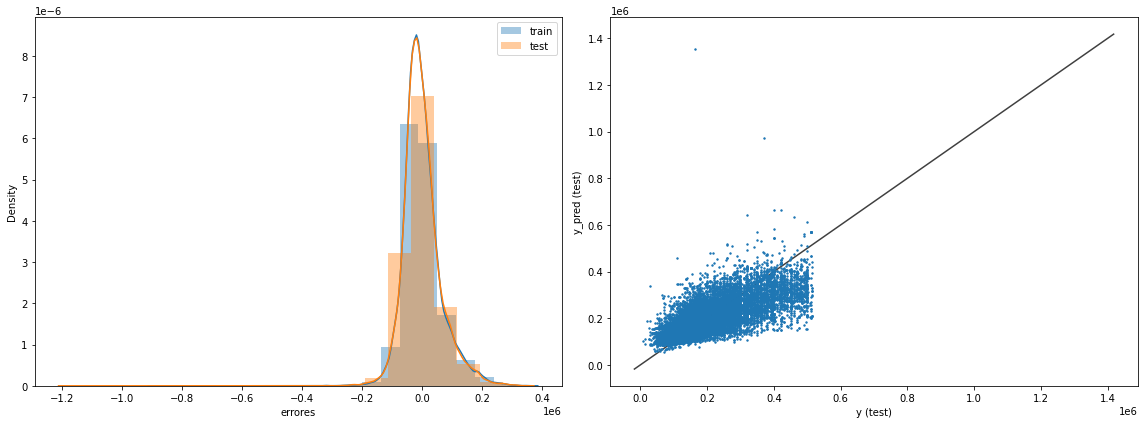

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 66628.6734880993
Raíz del error cuadrático medio en Test: 66438.2897967484


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


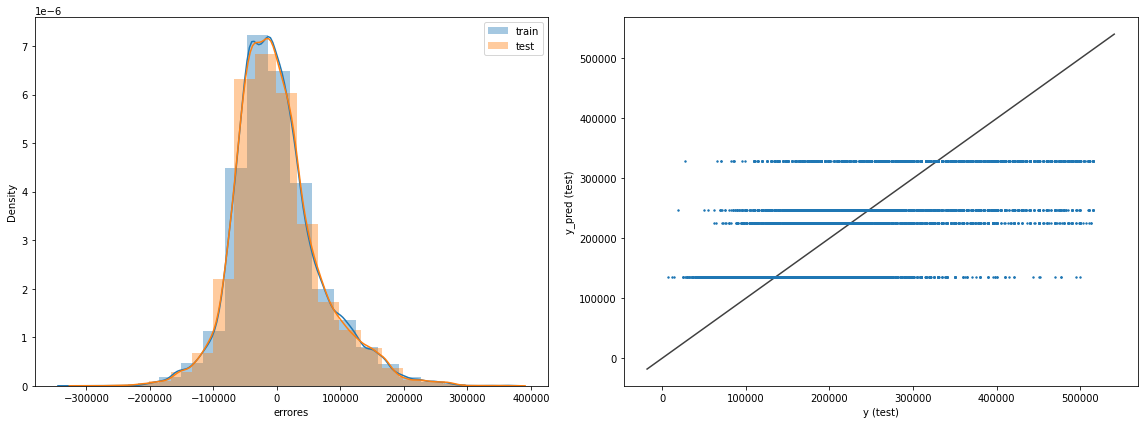

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 47465.611570261775
Raíz del error cuadrático medio en Test: 50661.59320592167


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


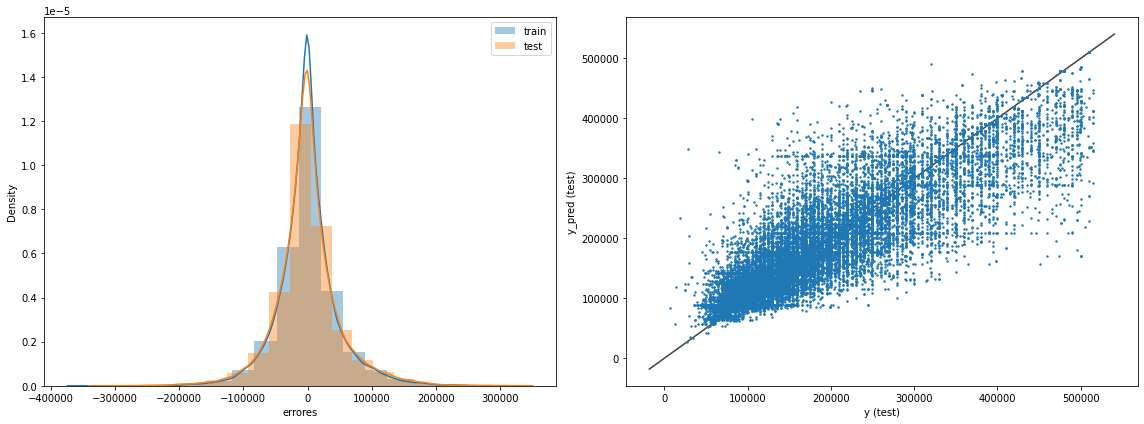

In [ ]:
from sklearn.metrics import mean_squared_error
modelos = ['Regresión lineal', 'Árbol de Decisión','Vecinos más cercanos']

for i, model in enumerate([linear_model, tree_regressor, knn_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f'Modelo: {modelos[i]}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (16,6))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()
    
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

Luego de entrenar los modelos del proyecto 1 con el dataset una vez realizado el trabajo de preprocesamiento, podemos observar que el resultado mejora considerablemente reduciendo el error en una buena cantidad respecto a los resultados obtenidos anteriormente.

Ahora vamos a pasar a la segunda parte del proyecto para trabajar el dataset con modelos avanzados de machine learning.

# **PARTE B - Modelos Avanzados**

***XGBoost: Extreme Gradient Boosting***

Voy a definir el modelo y a establecer una grilla de parámetros para, a su vez, a través del método random buscar con que parámetros encontramos mejor rendimiento. 

In [ ]:
# model = xgb.XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.2, use_label_encoder= False)
#model = xgb.XGBRegressor(n_estimators=100, max_depth=2, learning_rate=0.2)
#model = xgb.XGBRegressor(n_estimators=100, max_depth=50, learning_rate=0.2,min_samples_split=12)
xgb_reg = xgb.XGBRegressor()

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=1100, max_depth=5, learning_rate=0.1,min_samples_leaf =3 )

In [ ]:
model_xgb.fit(X_train, y_train)

[18:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, min_samples_leaf=3, missing=None,
             n_estimators=1100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_score_train = r2_score(y_train, y_train_pred)
r2_score_test = r2_score(y_test, y_test_pred)

print("RMSE Train: %f"%(rmse_train))
print("RMSE Test: %f"%(rmse_test))
print("Coeficiente de determinación Train: %f"%(r2_score_train))
print("Coeficiente de determinación Test: %f"%(r2_score_test))

RMSE Train: 44398.984861
RMSE Test: 48633.367210
Coeficiente de determinación Train: 0.787936
Coeficiente de determinación Test: 0.750183


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


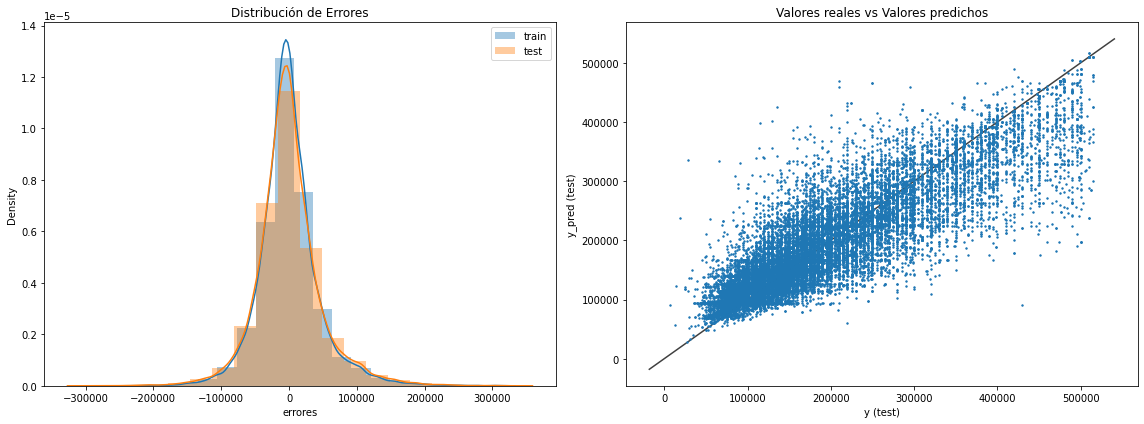

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.title('Distribución de Errores')
plt.legend()
    
ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
plt.title('Valores reales vs Valores predichos')

plt.tight_layout()
plt.show()

A considerar por los resultados y como se puede observar en las gráficas del modelo, para precios bajos predice dentro de lo esperado siendo que la dificultad en el modelo está para predecir valores altos, el mismo lo realiza por debajo del valor real.

En cuanto a la distribución de los errores en la gráfica podemos observar que la tendencia es simétrica, dando la forma de campana lo cual es una buena señal de que la predicción es buena, ya que además la vemos centrada sobre el 0. Entonces podemos asumir que los errores son parejos (tanto en lo positivo como los negativos), el modelo no tiende a siempre sobreestimando o siempre subestimando. Se equivoca parejo.
Vemos que las curvas de train y test son parejas, el modelo se equivoca también parejo en el entrenamiento y en el test. El modelo generaliza acorde a lo que sabe.

In [ ]:
model_xgb.feature_importances_

array([0.04424505, 0.05163619, 0.27119467, 0.193354  , 0.20083135,
       0.02086315, 0.13596576, 0.08190977], dtype=float32)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


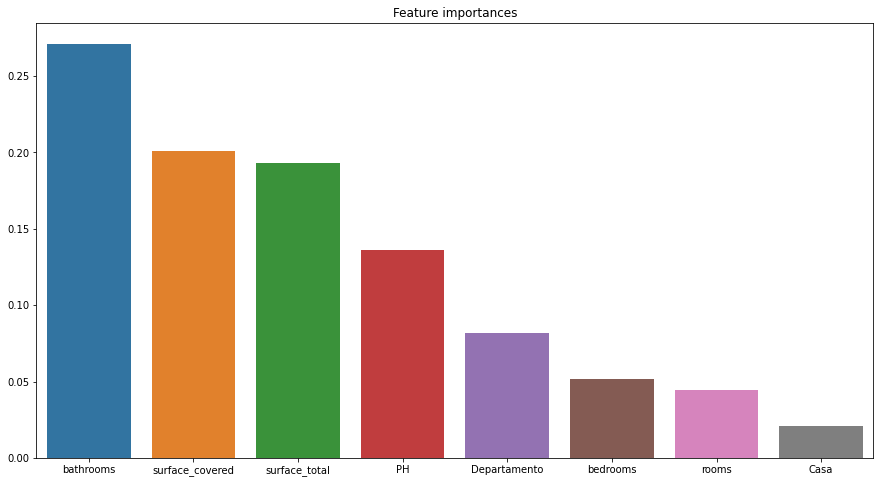

In [ ]:
importances = model_xgb.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15,8))
sns.barplot(columns[indices], importances[indices])
plt.title('Feature importances')
plt.show()

El modelo está tomando, llamativamente, como mayor importancia para predecir los precios la variable bathrooms. Como se vio en el proyecto 1, en el mapa de correlación, podría ser un indicador de la cantidad de rooms dada su correlación con esta última variable.
Siguiendo en importancia está surface (tanto covered como total). Quiere decir que al momento de valuar una propiedad, estas serán las variables más preponderantes de nuestro modelo para predecir. 
En parte se vieron beneficiadas por ser de las tratadas en el preprocesamiento cuando imputamos cuidadosamente valores faltantes. 
Vemos que el modelo también está teniendo en cuenta que tipo de propiedad es (como vemos en la importancia que le da a PH y Departamento, seguido por casa un poco más atrás).

El modelo mejora considerablemente los resultados obtenidos en el proyecto 1. De todas maneras se observa un leve sobreajuste aunque hasta el momento es el modelo de mejor rendimiento.

# **Hiperparametros XGBoost**

In [ ]:
n_estimators = [100,500,900,1100,1500]
max_depth = [1,2,3,4,5]
booster = ['gblinear']
learning_rate = [0.5,0.1,0.01,0.005]
min_samples_leaf = [1,2,3,4]
#min_child_weight = [1,2,3,4]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'min_samples_leaf': min_samples_leaf}

#             'min_child_weight': min_child_weight

In [ ]:
modelo = RandomizedSearchCV(xgb_reg, param_grid,n_iter=100 ,verbose=2,cv=4,random_state=42, n_jobs=-1)
modelo.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 61.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 66.0min finished


[18:00:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [ ]:
print("Mejores parametros: "+str(modelo.best_params_))
print("Mejor Score: "+str(modelo.best_score_)+'\n')

Mejores parametros: {'n_estimators': 900, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.5}
Mejor Score: 0.7366504145895759



In [ ]:
modelo = xgb.XGBRegressor(n_estimators=900, max_depth=5, learning_rate=0.5,min_samples_leaf =1 )

In [ ]:
modelo.fit(X_train, y_train)

[18:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=5, min_child_weight=1, min_samples_leaf=1, missing=None,
             n_estimators=900, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
y_train_pred_modelo = modelo.predict(X_train)
y_test_pred_modelo = modelo.predict(X_test)

rmse_train_mod = np.sqrt(mean_squared_error(y_train, y_train_pred_modelo))
rmse_test_mod = np.sqrt(mean_squared_error(y_test, y_test_pred_modelo))
r2_score_train_mod = r2_score(y_train, y_train_pred_modelo)
r2_score_test_mod = r2_score(y_test, y_test_pred_modelo)

print("RMSE Train: %f"%(rmse_train_mod))
print("RMSE Test: %f"%(rmse_test_mod))
print("Coeficiente de determinación Train: %f"%(r2_score_train_mod))
print("Coeficiente de determinación Test: %f"%(r2_score_test_mod))

RMSE Train: 38829.107603
RMSE Test: 48053.054411
Coeficiente de determinación Train: 0.837805
Coeficiente de determinación Test: 0.756109


In [ ]:
model.feature_importances_

array([0.04932548, 0.07724364, 0.25736904, 0.12320615, 0.2478637 ,
       0.02413572, 0.14279765, 0.07805872], dtype=float32)

Los resultados obtenidos para mi gusto no son mejores que el primer modelo de XGBoost, ya que si bien mejora el error en Train, el modelo tiende al overfitting en mayor proporción que el modelo inicial sin los hiperparámetros.

***PolynomialFeatures***

Voy a empezar este modelo generando atributos polinómicos y luego evaluar los distintos modelos de regresión: ***LinearRegression***, ***Ridge*** y ***Lasso***. Estos últimos dos pertenecen al proceso de regularización.

Voy a generar un modelo Polynomialfeatures y a través de la validación cruzada evaluar la regresión lineal utilizando el grado 2.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

In [ ]:
polynomial = PolynomialFeatures(degree = 2, include_bias= False)
X_polynomial = polynomial.fit_transform(X_train)

In [ ]:
print('--------------------------------------------------------')
print('PolynomialFeatures: LinearRegression')
print('--------------------------------------------------------')
rmse = cross_val_score(LinearRegression(n_jobs=-1), X_train, y_train, cv=9, scoring='neg_root_mean_squared_error', n_jobs=-1)
print(f'RAÍZ DEL ERROR CUADRÁTICO MEDIO: {-rmse.mean().round(2)} (+/- {rmse.std().round(2)})')
mse= cross_val_score(LinearRegression(n_jobs=-1), X_train,y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)
print(f'ERROR CUADRÁTICO MEDIO: {-mse.mean().round(2)} (+/- {mse.std().round(2)})')
r2= cross_val_score(LinearRegression(n_jobs=-1), X_train,y_train, cv=9, scoring='r2', n_jobs=-1)
print(f'COEFICIENTE DE DETERMINACIÓN: {r2.mean().round(2)}\n')

model = LinearRegression()
model.fit(X_train,y_train)
evaluar_regresion(model, X_train,X_test, y_train, y_test)

--------------------------------------------------------
PolynomialFeatures: LinearRegression
--------------------------------------------------------
RAÍZ DEL ERROR CUADRÁTICO MEDIO: 63052.53 (+/- 938.54)
ERROR CUADRÁTICO MEDIO: 3976501828.08 (+/- 118347278.47)
COEFICIENTE DE DETERMINACIÓN: 0.57

TRAIN:
RAIZ DEL ERROR CUADRÁTICO MEDIO:62999.06
COEFICIENTE DE DETERMINACIÓN:0.57
TEST:
RAIZ DEL ERROR CUADRÁTICO MEDIO:64142.09
COEFICIENTE DE DETERMINACIÓN:0.56


El modelo LinearRegression mejora muy levemente el resultado respecto del modelo realizado en el proyecto 1. Vamos a ver si podemos mejorar el rendimiento a través del proceso de Regularización.

# ***Regularización ***

***Ridge***

Aplico regularización Ridge con valores por defecto a los atributos polinómicos que obtuvimos unos pasos atrás.

In [ ]:
ridge= Ridge(random_state=5)
ridge.fit(X_train, y_train)

print('--------------------------------------------------------')
print('PolynomialFeatures: Ridge')
print('--------------------------------------------------------')
rmse = cross_val_score(ridge, X_train, y_train, cv=9, scoring='neg_root_mean_squared_error', n_jobs=-1)
print(f'RAÍZ DEL ERROR CUADRÁTICO MEDIO: {-rmse.mean().round(2)} (+/- {rmse.std().round(2)})')
mse= cross_val_score(ridge, X_train,y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)
print(f'ERROR CUADRÁTICO MEDIO: {-mse.mean().round(2)} (+/- {mse.std().round(2)})')
r2= cross_val_score(ridge, X_train,y_train, cv=9, scoring='r2', n_jobs=-1)
print(f'COEFICIENTE DE DETERMINACIÓN: {r2.mean().round(2)}\n')

evaluar_regresion(ridge,X_train, X_test, y_train, y_test)

--------------------------------------------------------
PolynomialFeatures: Ridge
--------------------------------------------------------
RAÍZ DEL ERROR CUADRÁTICO MEDIO: 63051.43 (+/- 937.27)
ERROR CUADRÁTICO MEDIO: 3976361457.59 (+/- 118186119.32)
COEFICIENTE DE DETERMINACIÓN: 0.57

TRAIN:
RAIZ DEL ERROR CUADRÁTICO MEDIO:62998.94
COEFICIENTE DE DETERMINACIÓN:0.57
TEST:
RAIZ DEL ERROR CUADRÁTICO MEDIO:64144.47
COEFICIENTE DE DETERMINACIÓN:0.56


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


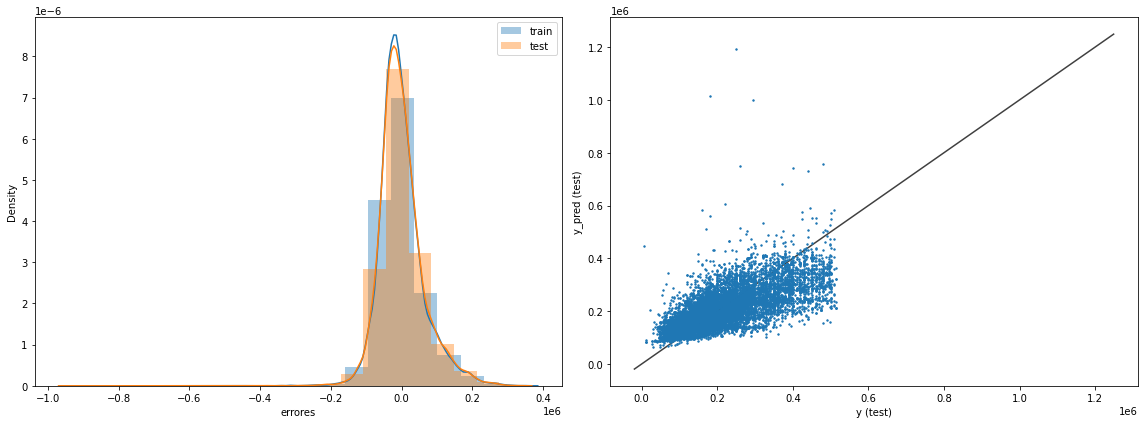

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()
    
ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

A través de un ciclo evaluamos distintos valores de alpha con el fin de encontrar el mejor rendimiento.

In [ ]:
alpha = [0.001, 0.005, 0.01, 0.1, 0.5, 1]
for i in alpha:
    ridge= Ridge(alpha= i, random_state=5)
    ridge.fit(X_train, y_train)
    print('-----------------------------------------------------------------------------')
    print(f'PolynomialFeatures: Ridge (alpha: {i})')
    print('-----------------------------------------------------------------------------')
    print(f'Pendientes: {ridge.coef_}')
    print(f'Ordenada: {ridge.intercept_}\n')

    evaluar_regresion(ridge,X_train, X_test, y_train, y_test)

-----------------------------------------------------------------------------
PolynomialFeatures: Ridge (alpha: 0.001)
-----------------------------------------------------------------------------
Pendientes: [17895.2234061   2154.72890551 30165.44211137  9488.75518698
 29805.02600668 -2539.99651341  5507.25185932 -4776.96876342]
Ordenada: 189218.18619374587

TRAIN:
RAIZ DEL ERROR CUADRÁTICO MEDIO:62998.94
COEFICIENTE DE DETERMINACIÓN:0.57
TEST:
RAIZ DEL ERROR CUADRÁTICO MEDIO:64144.56
COEFICIENTE DE DETERMINACIÓN:0.56
-----------------------------------------------------------------------------
PolynomialFeatures: Ridge (alpha: 0.005)
-----------------------------------------------------------------------------
Pendientes: [17895.21138524  2154.74355822 30165.43935026  9488.76173939
 29805.01671157 -2539.99604967  5507.25108705 -4776.96899375]
Ordenada: 189218.18615923545

TRAIN:
RAIZ DEL ERROR CUADRÁTICO MEDIO:62998.94
COEFICIENTE DE DETERMINACIÓN:0.57
TEST:
RAIZ DEL ERROR CUADRÁTICO

Observamos que no mejora el rendimiento respecto a LinearRegression.

# **Hiperparámetros**

In [ ]:
param_grid = {'alpha': np.array([0.01, 0.0001, 0.00001, 0.000001]),
              #'fit_intercept': [True],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparce_cg', 'saga'],
              }

In [ ]:
model_rid = RandomizedSearchCV(ridge, param_grid, n_iter=100, random_state=42, cv=5)

model_rid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got sparce_cg.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got sparce_cg.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_sele

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=5, solver='auto', tol=0.001),
                   iid='deprecated', n_iter=100, n_jobs=None,
                   param_distributions={'alpha': array([1.e-02, 1.e-04, 1.e-05, 1.e-06]),
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparce_cg',
                                                   'saga']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
print("Mejores parametros: "+str(model_rid.best_params_))
print("Mejor Score: "+str(model_rid.best_score_)+'\n')

Mejores parametros: {'solver': 'auto', 'alpha': 0.01}
Mejor Score: 0.5702942017633079



In [ ]:
scores = pd.DataFrame(model_rid.cv_results_)
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010044,0.002873,0.002472,0.000805,auto,0.01,"{'solver': 'auto', 'alpha': 0.01}",0.561397,0.573261,0.557562,0.576238,0.583013,0.570294,0.009457,1
1,0.013132,0.000861,0.002263,0.000065,svd,0.01,"{'solver': 'svd', 'alpha': 0.01}",0.561397,0.573261,0.557562,0.576238,0.583013,0.570294,0.009457,1
2,0.007227,0.000165,0.003026,0.002160,cholesky,0.01,"{'solver': 'cholesky', 'alpha': 0.01}",0.561397,0.573261,0.557562,0.576238,0.583013,0.570294,0.009457,1
3,0.016196,0.004500,0.003074,0.000854,lsqr,0.01,"{'solver': 'lsqr', 'alpha': 0.01}",0.561397,0.573261,0.557562,0.576238,0.583013,0.570294,0.009457,4
4,0.005930,0.000145,0.000000,0.000000,sparce_cg,0.01,"{'solver': 'sparce_cg', 'alpha': 0.01}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
5,0.084809,0.008221,0.002297,0.000104,saga,0.01,"{'solver': 'saga', 'alpha': 0.01}",0.561401,0.573250,0.557544,0.576234,0.582996,0.570285,0.009455,17
6,0.007114,0.000455,0.001912,0.000050,auto,0.0001,"{'solver': 'auto', 'alpha': 0.0001}",0.561397,0.573261,0.557562,0.576238,0.583013,0.570294,0.009457,5
7,0.013265,0.001155,0.002226,0.000229,svd,0.0001,"{'solver': 'svd', 'alpha': 0.0001}",0.561397,0.573261,0.557562,0.576238,0.583013,0.570294,0.009457,7
8,0.007322,0.000730,0.002323,0.000515,cholesky,0.0001,"{'solver': 'cholesky', 'alpha': 0.0001}",0.561397,0.573261,0.557562,0.576238,0.583013,0.570294,0.009457,5
9,0.011698,0.002450,0.002146,0.000024,lsqr,0.0001,"{'solver': 'lsqr', 'alpha': 0.0001}",0.561397,0.573261,0.557562,0.576238,0.583013,0.570294,0.009457,8


In [ ]:
ridge_dos= Ridge(solver='auto', alpha= 0.01)

In [ ]:
ridge_dos.fit(X_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
y_train_pred = ridge_dos.predict(X_train)
y_test_pred = ridge_dos.predict(X_test)

rmse_train_mod = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_mod = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_score_train_mod = r2_score(y_train, y_train_pred)
r2_score_test_mod = r2_score(y_test, y_test_pred)

print("RMSE Train: %f"%(rmse_train_mod))
print("RMSE Test: %f"%(rmse_test_mod))
print("Coeficiente de determinación Train: %f"%(r2_score_train_mod))
print("Coeficiente de determinación Test: %f"%(r2_score_test_mod))

RMSE Train: 62998.939276
RMSE Test: 64144.556513
Coeficiente de determinación Train: 0.570964
Coeficiente de determinación Test: 0.562283


El rendimiento se mantiene con los mismos valores de la regularización sin aplicar los hiperparámetros. 

Lasso

Continuamos con una regularización Lasso. Procedemos entrenando un modelo con valores por defecto.

In [ ]:
lasso= Lasso(random_state=5)
lasso.fit(X_train, y_train)

print('--------------------------------------------------------')
print('PolynomialFeatures: Lasso')
print('--------------------------------------------------------')
rmse = cross_val_score(lasso, X_train, y_train, cv=9, scoring='neg_root_mean_squared_error', n_jobs=-1)
print(f'RAÍZ DEL ERROR CUADRÁTICO MEDIO: {-rmse.mean().round(2)} (+/- {rmse.std().round(2)})')
mse= cross_val_score(lasso, X_train,y_train, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)
print(f'ERROR CUADRÁTICO MEDIO: {-mse.mean().round(2)} (+/- {mse.std().round(2)})')
r2= cross_val_score(lasso, X_train,y_train, cv=9, scoring='r2', n_jobs=-1)
print(f'COEFICIENTE DE DETERMINACIÓN: {r2.mean().round(2)}\n')

evaluar_regresion(lasso,X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4024660695267.1406, tolerance: 36821350743.59989
  positive)


--------------------------------------------------------
PolynomialFeatures: Lasso
--------------------------------------------------------
RAÍZ DEL ERROR CUADRÁTICO MEDIO: 63051.43 (+/- 937.25)
ERROR CUADRÁTICO MEDIO: 3976361464.6 (+/- 118183908.71)
COEFICIENTE DE DETERMINACIÓN: 0.57

TRAIN:
RAIZ DEL ERROR CUADRÁTICO MEDIO:62998.94
COEFICIENTE DE DETERMINACIÓN:0.57
TEST:
RAIZ DEL ERROR CUADRÁTICO MEDIO:64144.63
COEFICIENTE DE DETERMINACIÓN:0.56


Nuevamente nos ayudamos en la tarea de encontrar el mejor valor de α con un ciclo. Iteramos y comparamos los resultados.

In [ ]:
alpha = [0.001, 0.005, 0.01, 0.1, 0.5, 1]
for i in alpha:
    lasso= Lasso(alpha= i, random_state=5, warm_start= True)
    lasso.fit(X_train, y_train)
    print('-----------------------------------------------------------------------------')
    print(f'PolynomialFeatures: Lasso (alpha: {i})')
    print('-----------------------------------------------------------------------------')
    print(f'Pendientes: {lasso.coef_}')
    print(f'Ordenada: {lasso.intercept_}\n')

    evaluar_regresion(lasso,X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4023835083879.3125, tolerance: 36821350743.59989
  positive)


-----------------------------------------------------------------------------
PolynomialFeatures: Lasso (alpha: 0.001)
-----------------------------------------------------------------------------
Pendientes: [17895.22604451  2154.72490029 30165.44257087  9488.75219685
 29805.02828864 -1040.52396994  9057.18487136 -1481.63058828]
Ordenada: 189218.18620947222

TRAIN:
RAIZ DEL ERROR CUADRÁTICO MEDIO:62998.94
COEFICIENTE DE DETERMINACIÓN:0.57
TEST:
RAIZ DEL ERROR CUADRÁTICO MEDIO:64144.56
COEFICIENTE DE DETERMINACIÓN:0.56


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4023838426738.4375, tolerance: 36821350743.59989
  positive)


-----------------------------------------------------------------------------
PolynomialFeatures: Lasso (alpha: 0.005)
-----------------------------------------------------------------------------
Pendientes: [17895.22457726  2154.72353214 30165.44164779  9488.7467887
 29805.02812136 -1039.93419835  9058.56607707 -1480.34190565]
Ordenada: 189218.18623786714

TRAIN:
RAIZ DEL ERROR CUADRÁTICO MEDIO:62998.94
COEFICIENTE DE DETERMINACIÓN:0.57
TEST:
RAIZ DEL ERROR CUADRÁTICO MEDIO:64144.56
COEFICIENTE DE DETERMINACIÓN:0.56


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4023842580528.2344, tolerance: 36821350743.59989
  positive)


-----------------------------------------------------------------------------
PolynomialFeatures: Lasso (alpha: 0.01)
-----------------------------------------------------------------------------
Pendientes: [17895.22274319  2154.72182195 30165.44049393  9488.74002853
 29805.02791225 -1039.19698387  9060.2925842  -1478.73105235]
Ordenada: 189218.1862733608

TRAIN:
RAIZ DEL ERROR CUADRÁTICO MEDIO:62998.94
COEFICIENTE DE DETERMINACIÓN:0.57
TEST:
RAIZ DEL ERROR CUADRÁTICO MEDIO:64144.56
COEFICIENTE DE DETERMINACIÓN:0.56


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4023917349020.125, tolerance: 36821350743.59989
  positive)


-----------------------------------------------------------------------------
PolynomialFeatures: Lasso (alpha: 0.1)
-----------------------------------------------------------------------------
Pendientes: [17895.18972993  2154.69103851 30165.41972448  9488.61834533
 29805.02414833 -1025.92712313  9091.36971262 -1449.73569306]
Ordenada: 189218.18691224657

TRAIN:
RAIZ DEL ERROR CUADRÁTICO MEDIO:62998.94
COEFICIENTE DE DETERMINACIÓN:0.57
TEST:
RAIZ DEL ERROR CUADRÁTICO MEDIO:64144.56
COEFICIENTE DE DETERMINACIÓN:0.56


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4024248699310.047, tolerance: 36821350743.59989
  positive)


-----------------------------------------------------------------------------
PolynomialFeatures: Lasso (alpha: 0.5)
-----------------------------------------------------------------------------
Pendientes: [17895.04300434  2154.55422324 30165.32741581  9488.07753111
 29805.00741978  -966.94996427  9229.49028336 -1320.86742955]
Ordenada: 189218.18975173894

TRAIN:
RAIZ DEL ERROR CUADRÁTICO MEDIO:62998.94
COEFICIENTE DE DETERMINACIÓN:0.57
TEST:
RAIZ DEL ERROR CUADRÁTICO MEDIO:64144.6
COEFICIENTE DE DETERMINACIÓN:0.56
-----------------------------------------------------------------------------
PolynomialFeatures: Lasso (alpha: 1)
-----------------------------------------------------------------------------
Pendientes: [17894.85959736  2154.38320416 30165.21202997  9487.40151333
 29804.98650909  -893.2285157   9402.14099679 -1159.78210016]
Ordenada: 189218.19330110442

TRAIN:
RAIZ DEL ERROR CUADRÁTICO MEDIO:62998.94
COEFICIENTE DE DETERMINACIÓN:0.57
TEST:
RAIZ DEL ERROR CUADRÁTICO MEDIO:

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4024660695267.1406, tolerance: 36821350743.59989
  positive)


Seguimos obteniendo los mismos resultados que los modelos probados anteriormente. LinearRegression y Ridge

# **PARTE C - Interpretación de modelos**

*Luego de haber analizado los distintos modelos y habiendo optimizado los hiperparámetros se llega a la conclusión de que el modelo con el que mejor resultados obtuve fue el XGBoost. Si bien el modelo con mejor resultado tuvo un pequeño sobreajuste, mantuve el coeficiente de determinación cercano al 80% lo que, según las diversas pruebas hechas con distintos modelos, me indica que es un buen límite luego del preprocesamiento realizado.*

*Dentro del preprocesamiento considero que haber aplicado alguna técnica de clustering podría haber reducido el error y mejorar los rendimientos de los modelos. En las variables para trabajar quizás podría haber considerado las columnas latitud o longitud (alguna sola dada la correlatividad entre las dos).*
*Con respecto al resto del trabajo realizado en el preprocesamiento me siento conforme, se redujo el dataset en una proporción considerable para garantizar un trabajo cómodo y así poder realizar las comparaciones con los modelos entregados en el proyecto 1*

*Como error en el trabajo de preprocesamiento pienso que puede ser el haber inferido parte de la imputación de datos faltantes a estimaciones (como por ejemplo para completar los datos faltantes de bathrooms) y si hubiera utilizado otro método para llenar esos datos quizás el rendimiento hubiera sido mejor.*

*En cuanto al modelo de XGBoost que fue el que mejor resultado me arrojó, quizás podría haberlo mejorado aún más buscando más hiperparámetros en la grilla pero eso me llevaba al límite con el rendimiento de la pc y el proceso de entrenamiento duraba excesivamente.*